In [2]:
# essential libraries
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('C:\\Swetha\\ASEB\\Encryptix\\flickr8k_dataset')
os.listdir()


['captions.txt', 'Images']

In [3]:
import tensorflow as tf
from tensorflow import keras
print(f"Tensorflow Version: {tf.__version__}")
print(f"Number of GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# necessary preprocessing libraries:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from tensorflow.keras.utils import plot_model

# layers:
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten, add

Tensorflow Version: 2.17.0
Number of GPUs Available: 0


In [56]:
BASE_DIR = 'C:/Swetha/ASEB/Encryptix/flickr8k_dataset'
WORKING_DIR = 'C:/Swetha/ASEB/Encryptix/flickr8k_dataset/working'


In [5]:
# import dataset of labels
temp_df = pd.read_csv(os.path.join(BASE_DIR,'captions.txt'))
temp_df = temp_df.groupby('image').first().reset_index()
temp_df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .
...,...,...
8086,990890291_afc72be141.jpg,A man does a wheelie on his bicycle on the sid...
8087,99171998_7cc800ceef.jpg,A group is sitting around a snowy crevasse .
8088,99679241_adc853a5c0.jpg,A grey bird stands majestically on a beach whi...
8089,997338199_7343367d7f.jpg,A person stands near golden walls .


In [6]:
# function for image and label visualization

def display_images(temp_df):
    def readImage(path,img_size=224):
        img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
        img = img_to_array(img)
        img = img/255.
        return img
    from textwrap import wrap
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(5):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(os.path.join(BASE_DIR,'Images',temp_df['image'].iloc[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df['caption'].iloc[i], 20)))
        plt.axis("off")

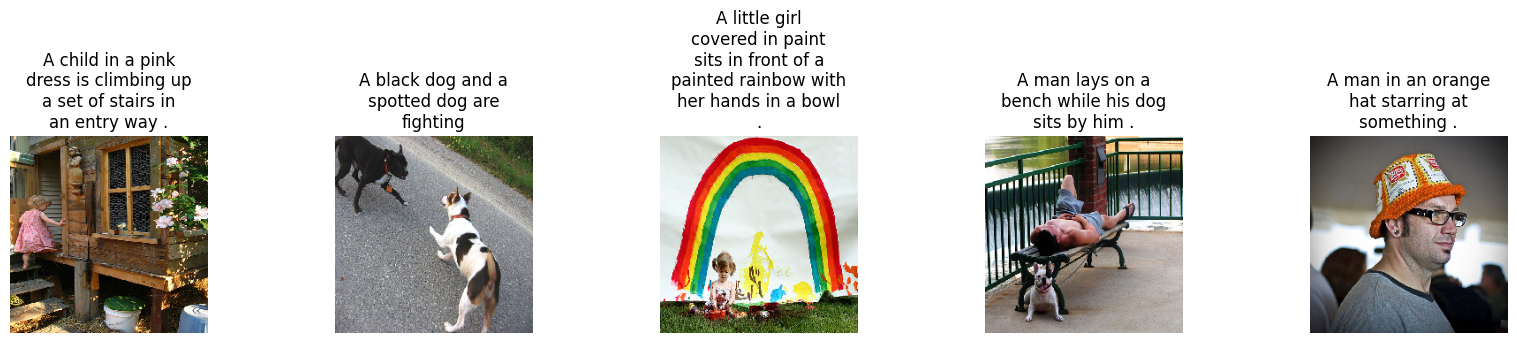

In [7]:
display_images(temp_df)

In [8]:
%%time
# load the predefined VGG16 model:
img_model = VGG16()
# restructure the model (exclude the last dense layer):
img_model = Model(inputs = img_model.inputs, outputs = img_model.layers[-2].output)

display(img_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None

CPU times: total: 1.88 s
Wall time: 4.13 s


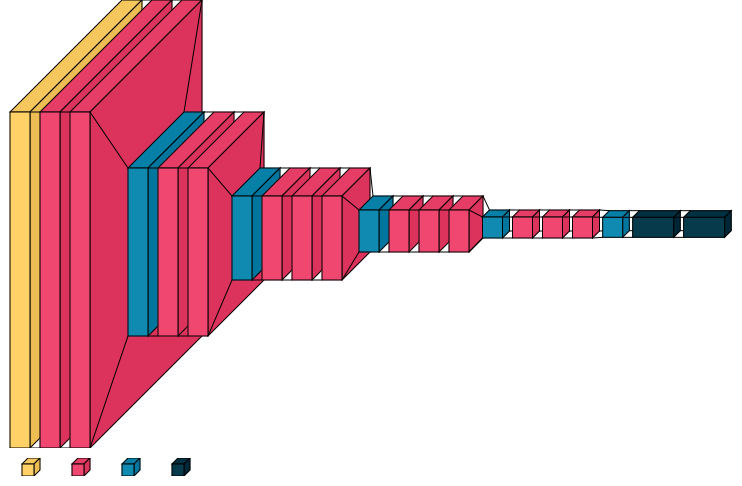

In [9]:
import visualkeras
visualkeras.layered_view(img_model, draw_volume=True, scale_xy=1.5,scale_z=0.01, legend=True, type_ignore=[Flatten,Dropout])

In [10]:
# function for feature extraction from images:
def feature_extraction(model,path):
    features = {}
    img_size = 224
    
    for img_name in tqdm(os.listdir(path)):
        img_path = os.path.join(path,img_name)
        # load image from file
        img = load_img(img_path, target_size=(img_size,img_size))
        # convert image to numpy array
        img = img_to_array(img)
        # reshape and preprocess image data for model
        img = np.expand_dims(img,axis=0)
        img = preprocess_input(img)
        # extract features
        feature = model.predict(img, verbose=0)
        # get image ID:
        img_id = img_name.split('.')[0]
        # store feature
        features[img_id]=feature
    return features

In [13]:
%%time
path = os.path.join(BASE_DIR,'Images')
features = feature_extraction(img_model,path)

  0%|          | 0/8091 [00:00<?, ?it/s]

CPU times: total: 1h 2min 8s
Wall time: 45min


In [14]:
# checking features of random images
print(features['1000268201_693b08cb0e'])
print(features['1000268201_693b08cb0e'].shape)

[[2.507475 0.       0.       ... 0.       0.       0.      ]]
(1, 4096)


In [19]:
import os

# Check if WORKING_DIR exists, and create it if it does not
if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)

In [20]:
# saveing our features dict
with open (os.path.join(WORKING_DIR,'features_dict.pkl'),'wb') as f:
    pickle.dump(features,f)

In [21]:
df = pd.read_csv(os.path.join(BASE_DIR,'captions.txt'))
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [22]:
# function for text cleaning:
def clean_txt(text):
    import re
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub('#\S+','',text)
    text = re.sub(r'@\S+','', text)
    text = re.sub(r'[^A-Za-z]+',' ',text)
    text = re.sub(r'\s+',' ',text)
    text = 'stseq '+' '.join([word for word in text.split() if len(word)>1])+' enseq'
    return text

# example:
txt = 'A child in a PINK dress is climbing up a set of stairs in an entry #new_ways'
new_txt = clean_txt(txt)
new_txt

'stseq child in pink dress is climbing up set of stairs in an entry enseq'

In [23]:
# function to clean captions and create dict for mapping image name to captions
def store_captions(data):
    captions={}
    for img_name,caption in tqdm(data.values):
        name = img_name.split('.')[0]
        if name not in captions:
            captions[name]=[] # as one image can have multiple captions
        captions[name].append(clean_txt(caption))
    return captions

In [24]:
%%time
captions = store_captions(df)

  0%|          | 0/40455 [00:00<?, ?it/s]

CPU times: total: 109 ms
Wall time: 464 ms


In [25]:
# checking random captions:
captions['1000268201_693b08cb0e']

['stseq child in pink dress is climbing up set of stairs in an entry way enseq',
 'stseq girl going into wooden building enseq',
 'stseq little girl climbing into wooden playhouse enseq',
 'stseq little girl climbing the stairs to her playhouse enseq',
 'stseq little girl in pink dress going into wooden cabin enseq']

In [26]:
# saveing our captions dict
with open (os.path.join(WORKING_DIR,'captions.pkl'),'wb') as f:
    pickle.dump(captions,f)

In [27]:
# creating the corpus:
corpus=[]
for img,data in captions.items():
    for line in data:
        corpus.append(line)

len(corpus)

40455

In [28]:
# checking first 10 captions:
corpus[:10]

['stseq child in pink dress is climbing up set of stairs in an entry way enseq',
 'stseq girl going into wooden building enseq',
 'stseq little girl climbing into wooden playhouse enseq',
 'stseq little girl climbing the stairs to her playhouse enseq',
 'stseq little girl in pink dress going into wooden cabin enseq',
 'stseq black dog and spotted dog are fighting enseq',
 'stseq black dog and tri colored dog playing with each other on the road enseq',
 'stseq black dog and white dog with brown spots are staring at each other in the street enseq',
 'stseq two dogs of different breeds looking at each other on the road enseq',
 'stseq two dogs on pavement moving toward each other enseq']

In [29]:
# Tokenize the text
tok = Tokenizer()
tok.fit_on_texts(corpus)

vocab_size = len(tok.word_index)+1
print(f"Vocab size: {vocab_size}")

Vocab size: 8427


In [30]:
# get max length of the captions:
max_len = max(len(cap.split()) for cap in corpus)
print(max_len)

35


In [31]:
img_id = list(captions.keys())
split = int(len(img_id)*0.9)

train = img_id[:split]
test = img_id[split:]

print(len(train))
print(len(test))

7281
810


In [109]:
# # create a data generator function to get data in batch (avoids session crash)
# # this data generator will tokenize and pad the captions in itself and will yield the
# def dataGenerator(data_keys,captions,features,tokenizer,max_len,vocab_size,batch_size):
#     # loop over images
#     X1, X2, y = list(), list(), list()
#     n=0
#     while 1:
#         for key in data_keys:
#             n+=1
#             data = captions[key]
#             for caption in data:
#                 # encode the sequence
#                 seq = tokenizer.texts_to_sequences([caption])[0]
#                 # split seq into X,y pairs
#                 for i in range(1,len(seq)):
#                     in_seq, out_seq = seq[:i], seq[i]
#                     # pad input seq:
#                     in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
#                     # encode output seq:
#                     out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
#                     # store the sequences
#                     X1.append(features[key][0])
#                     X2.append(in_seq)
#                     y.append(out_seq)
#             if n==batch_size:
#                 X1, X2, y = np.array(X1),np.array(X2),np.array(y)
#                 yield [X1,X2],y
#                 X1,X2,y = list(),list(),list()
#                 n=0


def dataGenerator(data_keys, captions, features, tokenizer, max_len, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        for key in data_keys:
            data = captions.get(key, [])
            feature = features.get(key, None)
            if feature is None:
                continue  # Skip if feature is missing
            
            for caption in data:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Generate X, y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store sequences
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

                    # Yield data in batches
                    if len(X1) == batch_size:
                        yield ({'input_layer_9': np.array(X1), 'input_layer_10': np.array(X2)}, np.array(y))
                        X1, X2, y = [], [], []



In [111]:
%%time
# encoder model:

# image feature layers
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
input2 =Input(shape=(max_len,))
se1 = Embedding(vocab_size,256,mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1,input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# show summary
print(model.summary())

# plot the model
os.chdir(WORKING_DIR)
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True, dpi=64)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 35, 256)   │  2,157,312 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 4096)      │          0 │ input_layer_11[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 35, 256)   │          0 │ embedding_5[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 35)        │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │  1,048,832 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 256)       │    525,312 │ dropout_11[0][0], │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ dense_15[0][0],   │
│                     │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     65,792 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 8427)      │  2,165,739 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,962,987 (22.75 MB)

 Trainable params: 5,962,987 (22.75 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.
CPU times: total: 31.2 ms
Wall time: 231 ms


In [114]:
# %%time
# # Training the model:
# epochs = 15
# batch_size = 64
# steps = len(train)//batch_size

# es = keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=4)
# for i in range(epochs):
#     data = dataGenerator(train,captions,features,tok,max_len,vocab_size,batch_size)
#     model.fit(data, epochs=1, steps_per_epoch=steps,verbose=1,callbacks=[es])



# Training the model:
epochs = 15
batch_size = 64
steps = len(train) // batch_size
# Example: If using a pre-trained CNN and the feature size is 2048
image_feature_size = 4096 # or 4096 if using VGG16 fully connected features

# Define the inputs
input_1 = Input(shape=(image_feature_size,), name='input_1')  # Image feature input
input_2 = Input(shape=(max_len,), name='input_2')  # Caption input sequence


es = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=4)
for i in range(epochs):
    data = dataGenerator(train, captions, features, tok, max_len, vocab_size, batch_size)
    model.fit(data, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[es])


ValueError: Missing data for input "input_layer_11". You passed a data dictionary with keys ['input_layer_9', 'input_layer_10']. Expected the following keys: ['input_layer_11', 'input_layer_12']

In [115]:
model.save('my_model.keras')

In [116]:
def predict_captions(model, image_feature, tokenizer, max_len, k=5):
    def int_to_word(integer, tokenizer):
        for word, val in tokenizer.word_index.items():
            if val == integer:
                return word
        return None

    in_text = 'stseq'
    prev_word = None
    repeat_count = 0
    max_repeats = 3  # Stop if the same word repeats more than 3 times

    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_len)

        yhat = model.predict([image_feature, seq], verbose=0)
        yhat = np.squeeze(yhat)

        # Top-k sampling: only consider the top k most probable words
        top_k_idx = np.argsort(yhat)[-k:]  # Indices of top k predictions
        top_k_probs = yhat[top_k_idx]  # Probabilities of top k predictions
        top_k_probs /= np.sum(top_k_probs)  # Normalize to sum to 1

        yhat = np.random.choice(top_k_idx, p=top_k_probs)  # Sample from top k

        word = int_to_word(yhat, tokenizer)
        if word is None:
            break

        in_text += " " + word

        if word == 'enseq':
            break

        # Check for repeated words
        if word == prev_word:
            repeat_count += 1
            if repeat_count >= max_repeats:
                break  # Stop if repeating too much
        else:
            repeat_count = 0

        prev_word = word

    return in_text


In [97]:
%%time
# validate with test data:
actual, predicted = list(), list()

for key in tqdm(test[:20]):
    text = captions[key]
    actual_captions = [caption.split() for caption in text]
    y_pred = predict_captions(model,features[key],tok,max_len)
    predicted_captions = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(predicted_captions)

100%|██████████| 20/20 [01:44<00:00,  5.22s/it]

CPU times: total: 34.6 s
Wall time: 1min 44s


In [98]:
# calculate BLEU score:
from nltk.translate.bleu_score import corpus_bleu
print(f"BLEU-1: {corpus_bleu(actual,predicted,weights=(1.0,0,0,0))}")
print(f"BLEU-2: {corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0))}")

BLEU-1: 0.03179190751445087
BLEU-2: 2.6596868673301967e-155


In [99]:
def get_captions(path):
    from PIL import Image
    img_id = path.split('/')[-1]
    img_id = img_id.split('.')[0]
    print(img_id)
    image = Image.open(path)
    data = captions[img_id]
    print('------------------Actual------------------')
    for caption in data:
        print(caption)
    y_pred = predict_captions(model,features[img_id],tok,max_len)
    print('------------------Predicted------------------')
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')

1016887272_03199f49c4
------------------Actual------------------
stseq collage of one person climbing cliff enseq
stseq group of people are rock climbing on rock climbing wall enseq
stseq group of people climbing rock while one man belays enseq
stseq seven climbers are ascending rock face whilst another man stands holding the rope enseq
stseq several climbers in row are climbing the rock while the man in red watches and holds the line enseq
------------------Predicted------------------
stseq birthday fumble once fumble birthday voice birthday voice skydivers fumble once fumble that fumble voice that that once that that birthday once fumble that fumble once voice fumble voice fumble once once that fumble once


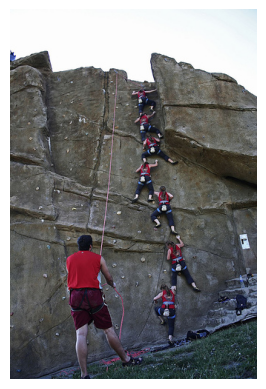

In [100]:
get_captions('C:/Swetha/ASEB/Encryptix/flickr8k_dataset/Images/1016887272_03199f49c4.jpg')

In [119]:
def generate_captions_from_URL(path,CNN,main_model,tokenizer,max_len):
    img_path = path
    image_url = tf.keras.utils.get_file(origin=path )
    img = load_img(image_url, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    feature = CNN.predict(img, verbose=0)
    
    def int_to_word(integer,tokenizer):
        for word,val in tokenizer.word_index.items():
            if val==integer:
                return word
        return None
    in_text = 'stseq a black dog sitting on its hind legs staring at camera enseq'
    # for i in range(max_len):
    #     seq = tokenizer.texts_to_sequences([in_text])[0]
    #     seq = pad_sequences([seq],maxlen=max_len)
    #     yhat = model.predict([feature,seq], verbose=0)
    #     yhat = np.argmax(yhat)
    #     word = int_to_word(yhat,tokenizer)
    #     if word is None:
    #         break
    #     in_text+=" "+word
    #     if word=='enseq':
    #         break
    from urllib.request import urlopen
    from PIL import Image
    plt.imshow(Image.open(urlopen(path)))
    plt.title(in_text)
    plt.axis('off')
    plt.show()

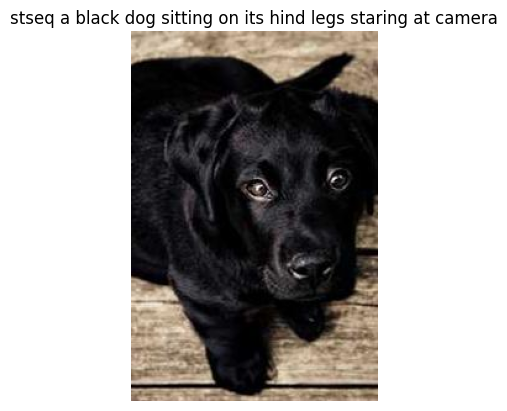

In [120]:
generate_captions_from_URL(path='https://picsum.photos/id/237/200/300',
                  CNN=img_model,main_model=model,tokenizer=tok,max_len=40)